In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
from scipy.stats import ttest_1samp, ttest_rel
from sklearn.metrics import r2_score
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [4]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [5]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [6]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [79]:
dname = join(dir_git,'AnatSearchlight')
sys.path.append(dname)
import AnatSearchlight.searchlight as sl

In [7]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import stat as sstat
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [8]:
list_sn = su.get_list_sn()
# list_roi = simage.get_list_roi()
list_run = su.get_list_run()

In [18]:
dir_group = join(ssingle.get_dir_glmsingle(),'surfaceWB/group')
dir_group

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB/group'

---

|(K,P)|ch $_{1}$|ch $_{2}$|$\cdots$|$i^{th}$ profile|$\cdots$|ch $_{P-1}$|ch $_{P}$| 
|-----|-----|-----|-----|-----|-----|-----|-----|
|cond $_{1}$|$\cdot$|$\cdot$|$\cdots$|$\cdot$|$\cdots$|$\cdot$|$\cdot$|
|cond $_{2}$|$\cdot$|$\cdot$|$\cdots$|$\cdot$|$\cdots$|$\cdot$|$\cdot$|
|$\vdots$|$\vdots$|$\vdots$|$\ddots$|$\vdots$|$\ddots$|$\cdot$|$\cdot$|
|$j^{th}$ pattern|$\cdot$|$\cdot$|$\cdots$|$\cdot$|$\cdots$|$\cdot$|$\cdot$|
|$\vdots$|$\vdots$|$\vdots$|$\ddots$|$\vdots$|$\ddots$|$\cdot$|$\cdot$|
|cond $_{K-1}$|$\cdot$|$\cdot$|$\cdots$|$\cdot$|$\cdots$|$\cdot$|$\cdot$|
|cond $_{K}$|$\cdot$|$\cdot$|$\cdots$|$\cdot$|$\cdots$|$\cdot$|$\cdot$|

1) Whole Brain: Pattern Analysis
2) ROI: Profile Analysis

In [9]:
dir_roi = su.get_dir_roi()

In [10]:
border, brdr = simage.get_border(dir_git=dir_git, atlas='sulcus')
# border, brdr = simage.get_border(dir_git=dir_git, atlas='Glasser')
hem = 'L'

In [11]:
fname = join(dir_roi, 'SPark.32k.L.dlabel.nii')
cii = nb.load(fname)
mask = cii.get_fdata()[0].astype(int)

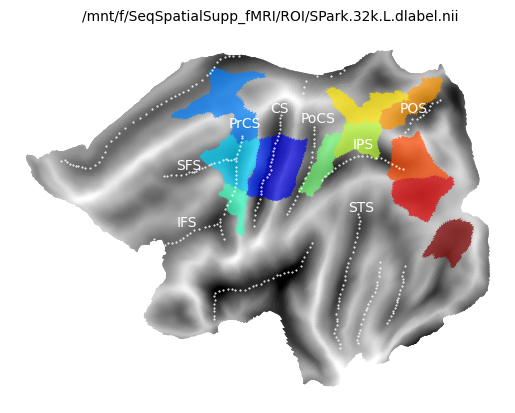

In [12]:
g = surf.plot.plotmap(
    data=mask,
    surf='fs32k_%s'%hem,
    alpha=0.7,
    cmap=cm.jet.resampled(len(np.unique(mask))),
    # colorbar=True,
    # cscale=[-1,7],
    # threshold=[-thresh,thresh],
    borders=border, bordercolor='white', bordersize=1,
    overlay_type='func', render='matplotlib',
)
g.text(x=20, y=220, s=fname, ha='center', va='center', fontsize=10)
for line, (x, y) in brdr.items():
    g.text(x=x, y=y, s=line, ha='left', va='bottom', color='white', fontsize=10)

In [23]:
list_roi = ['S1','M1','SMA','PMd','PMv','SPLa','SPLp','BA7','POS','Dor','Mid','Ven']

---

In [13]:
dir_surf = join(ssingle.get_dir_glmsingle(),'surfaceWB')
dir_surf

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB'

In [14]:
dir_group = join(dir_surf,'group')

---

In [46]:
def extract_data(data, mask, list_roi):
    result = {}
    for ii, roi in enumerate(list_roi):
        assert data.shape[-1] == mask.shape[0]
        val = ii+1
        idx = mask==val

        result[roi] = data[:,idx].mean(axis=-1)

    return result

In [55]:
df = pd.DataFrame()

## 1. Overall Activity

In [56]:
lines = {'category':[],'roi':[],'cond':[],'subj':[],'value':[]}

In [57]:
glm = 1
category = 'overall'

In [58]:
dir_work = join(dir_surf,'glm_%1d'%glm)

In [59]:
for ii, cue in enumerate(['letter','spatial']):
    fname = join(dir_work,'smooth.cifti.%s.glm_%1d.beta_mean.%s.dscalar.nii'%(hem,glm,cue))
    cii = nb.load(fname)
    data = cii.get_fdata()
    res = extract_data(data=data, mask=mask, list_roi=list_roi)
    for roi, values in res.items():
        for jj, value in enumerate(values):
            sn = list_sn[jj]
            subj = 'S'+sn
            lines['category'].append(category)
            lines['roi'].append(roi)
            lines['cond'].append(cue)
            lines['subj'].append(subj)
            lines['value'].append(value)
dg = pd.DataFrame(lines)
df = pd.concat([df,dg])

## 2. RS Effect

In [61]:
lines = {'category':[],'roi':[],'cond':[],'subj':[],'value':[]}

In [62]:
glm = 2
category = 'RS_effect'

In [63]:
dir_work = join(dir_surf,'glm_%1d'%glm)

In [64]:
for ii, cue in enumerate(['letter','spatial']):
    for jj, cond in enumerate(['wRS','acRS']):
        fname = join(dir_work,'smooth.cifti.%s.glm_%1d.beta_mean.%s_%s.dscalar.nii'%(hem,glm,cond,cue))
        cii = nb.load(fname)
        data = cii.get_fdata()
        res = extract_data(data=data, mask=mask, list_roi=list_roi)
        for roi, values in res.items():
            for kk, value in enumerate(values):
                sn = list_sn[kk]
                subj = 'S'+sn
                lines['category'].append(category)
                lines['roi'].append(roi)
                lines['cond'].append('%s_%s'%(cond,cue))
                lines['subj'].append(subj)
                lines['value'].append(value)
dg = pd.DataFrame(lines)
df = pd.concat([df,dg])

## 3. RSA

In [93]:
def map_data2surf(data, mySearchlight):
    surf = np.ones((data.shape[0],32492)) * np.nan
    
    ## check the indeces of centers
    idx = mySearchlight.center_indx
    for ii, dd in enumerate(data):
        surf[ii,idx] = dd

    return surf

In [94]:
lines = {'category':[],'roi':[],'cond':[],'subj':[],'value':[]}

In [95]:
glm = 1
category = 'RSA'

In [96]:
dir_work = join(dir_surf,'glm_%1d'%glm)

In [97]:
for jj, sn in enumerate(tqdm(list_sn)):
    subj = 'S'+sn
    ## load the setup file
    fname = join(su.get_dir_surf(),subj,'%s.%s.searchlight_surface.nvoxel=200.h5'%(subj,hem))
    mySearchlight = sl.load(fname)
    
    for ii, cue in enumerate(['letter','spatial']):    
        fname = join(dir_work,subj,'%s.%s.glm_%1d.searchlight.mean_dist.%s.dscalar.nii'%(subj,hem,glm,cue))
        cii = nb.load(fname)
        data = cii.get_fdata()
        data = map_data2surf(data=data, mySearchlight=mySearchlight)
        res = extract_data(data=data, mask=mask, list_roi=list_roi)
        for roi, values in res.items():
            value = values[0]
            lines['category'].append(category)
            lines['roi'].append(roi)
            lines['cond'].append(cue)
            lines['subj'].append(subj)
            lines['value'].append(value)
dg = pd.DataFrame(lines)
df = pd.concat([df,dg])

100%|███████████████████████████████████████████████████| 12/12 [06:16<00:00, 31.41s/it]


---

### i) Save the `df`

In [99]:
fname = join(dir_group,'GLMsingle.ROI.csv')
df.to_csv(fname, index=False, encoding="utf-8")

### ii) Load the `df`

In [100]:
fname = join(dir_group,'GLMsingle.ROI.csv')
dg = pd.read_csv(fname, encoding="utf-8")

In [98]:
df

,category,roi,cond,subj,value
0,overall,S1,letter,S01,138.570632
1,overall,S1,letter,S02,112.226629
2,overall,S1,letter,S03,93.983156
3,overall,S1,letter,S05,190.969289
4,overall,S1,letter,S06,177.350423
...,...,...,...,...,...
283,RSA,BA7,spatial,S14,0.001255
284,RSA,POS,spatial,S14,0.000539
285,RSA,Dor,spatial,S14,0.002731
286,RSA,Mid,spatial,S14,0.004433


---

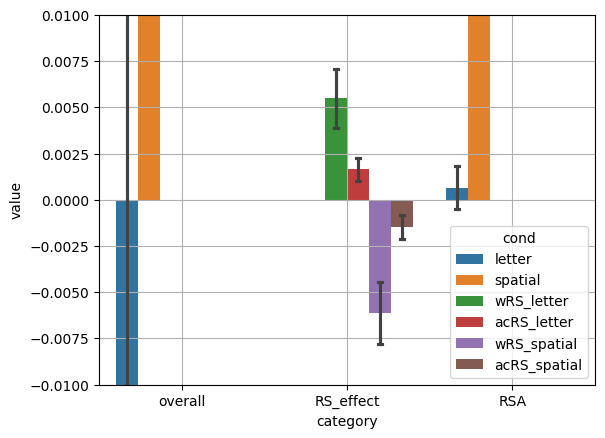

In [116]:
roi = 'Ven'
g = sns.barplot(
    data=df[df.roi==roi],
    x='category', y='value', hue='cond',
    capsize=0.15, errorbar='se'
)
g.set_ylim(-0.01,0.01)
g.grid(axis='both')

---